<a href="https://colab.research.google.com/github/Tierprot/Deep-Learning/blob/master/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import itertools
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/'My Drive'/Colab_Notebooks/22.01.20/utils.py

import sys
sys.path.append('/content/gdrive/My Drive/Colab_Notebooks')
from utils import mnist, plot_graphs, plot_mnist, mnist_transform

'/content/gdrive/My Drive/Colab_Notebooks/22.01.20/utils.py'


In [5]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20930488.23it/s]                            


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


32768it [00:00, 315978.49it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


1654784it [00:00, 5115494.52it/s]                           
8192it [00:00, 129224.90it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw
Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


In [0]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [0]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [0]:
models = {'2': Net(2), '64': Net(64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def add_noise(x, mode='crop', elementwise=False):
    if np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            dim = x[0][0].shape[0]
            for i in range(x.shape[0]):
                coords = [[0, int(dim/2)],
                          [int(dim/2),dim]]
                p = {label: [coord[0], coord[1]] for label,coord in enumerate(itertools.product(coords,coords))}
                l, a = np.random.randint(4), np.random.randint(1,3)
                x[i, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]]=x[i, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]].flip(a)       
        
        elif mode == 'gaussian':
            size = x[0][0].size()
            std_rand = 1.5
            mean_rand = 0
            std = 0.5
            mean = 0.5
            for i in range(x.shape[0]):
                x[i, :,] += x[i, :, ] + torch.randn(size) * std_rand + mean_rand
                x[i, :,] = (x[i, :,] - x[i, :,].mean())/(x[i, :,].std()/std) + mean 
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
        if mode == 'mirror':
            dim = x[0][0].shape[0]
            coords = [[0, int(dim/2)],
                      [int(dim/2),dim]]

            #агрегатор для различных сочетаний, чтобы сделать какую-либо часть картинки отзеркаленной
            p = {label: [coord[0], coord[1]] for label,coord in enumerate(itertools.product(coords,coords))}
            # for item in p:
            #     print(item, p[item])
            # l - часть кaртинки, а - ось по которой отражаем
            l, a = np.random.randint(4), np.random.randint(2,4)
            # print(l, a)
            x[:, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]]=x[:, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]].flip(a)       
        if mode == 'gaussian':
            size = x[0][0].size()
            std_rand = 1.5
            mean_rand = 0
            std = 0.5
            mean = 0.5
            x[:, :] += x[:, :] + torch.randn(size) * std_rand + mean_rand
            x[:, :,] = (x[:, :,] - x[:, :,].mean())/(x[:, :,].std()/std)+mean            
    return x

In [0]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data, mode='gaussian')
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [0]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data, mode='gaussian')
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [14]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 2: 1.102491 64: 0.998630
Train Epoch: 1 [30000/60000] 2: 1.035910 64: 0.454550
Train Epoch: 1 [60000/60000] 2: 1.008911 64: 0.307663
Test set:
2: loss: 1.0073
64: loss: 0.3139

Train Epoch: 2 [00000/60000] 2: 1.011518 64: 0.311879
Train Epoch: 2 [30000/60000] 2: 0.980834 64: 0.290107
Train Epoch: 2 [60000/60000] 2: 0.952396 64: 0.275747
Test set:
2: loss: 0.9514
64: loss: 0.2752

Train Epoch: 3 [00000/60000] 2: 0.953935 64: 0.263662
Train Epoch: 3 [30000/60000] 2: 0.919416 64: 0.273876
Train Epoch: 3 [60000/60000] 2: 0.886326 64: 0.266437
Test set:
2: loss: 0.8858
64: loss: 0.2636

Train Epoch: 4 [00000/60000] 2: 0.886592 64: 0.251076
Train Epoch: 4 [30000/60000] 2: 0.848707 64: 0.257385
Train Epoch: 4 [60000/60000] 2: 0.812916 64: 0.257512
Test set:
2: loss: 0.8131
64: loss: 0.2526

Train Epoch: 5 [00000/60000] 2: 0.812239 64: 0.246091
Train Epoch: 5 [30000/60000] 2: 0.774411 64: 0.244516
Train Epoch: 5 [60000/60000] 2: 0.739354 64: 0.245276
Test set:
2: l

In [0]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='gaussian', elementwise=True)
output = models['64'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

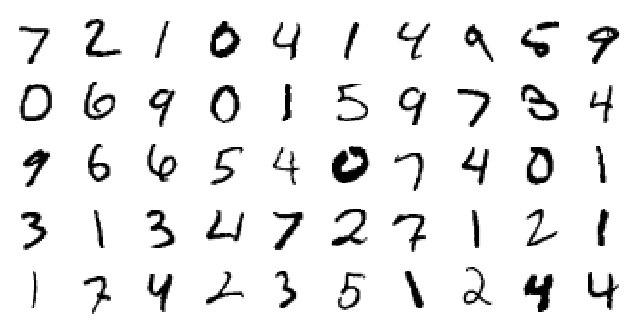

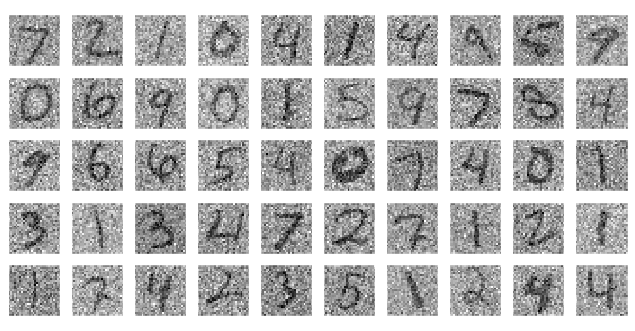

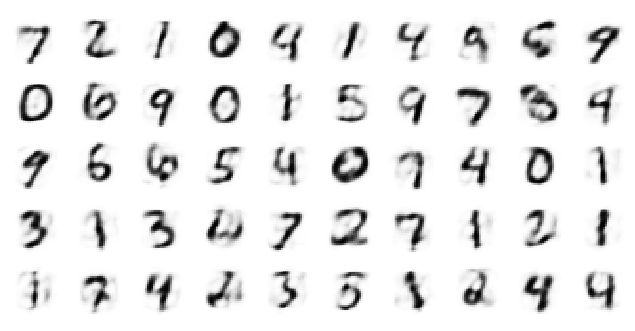

In [51]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

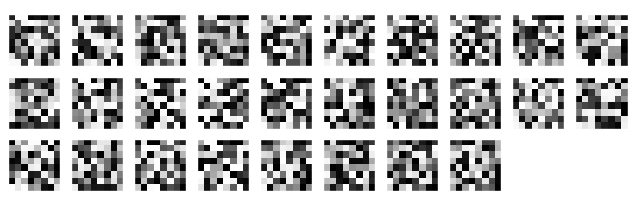

In [53]:
# латентное представление (для 64-мерного слоя - так интереснее)

def get_some_class(data, labels, subclass):
    mask=labels.eq(subclass)
    return torch.masked_select(data, mask)

data, labels = next(iter(test_loader))
class_ = 4
mask = labels.eq(class_)
output = models['64'].E(data[mask].view(-1, 28*28))
to_plot = output.view(-1, 1, 8, 8).data.numpy()
plot_mnist(to_plot, (5, 10))



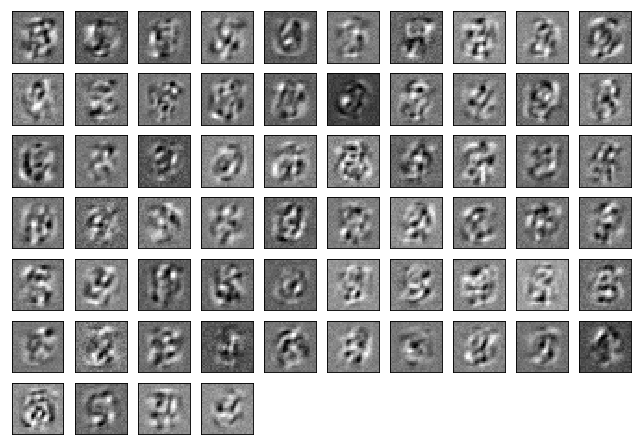

In [18]:
# активационный слой для 64х нейронного кодировщика

activation = models['64'].E.fc1.weight
to_plot = activation.view(-1,1,28,28).data.numpy()
plot_mnist(to_plot, (7, 10))

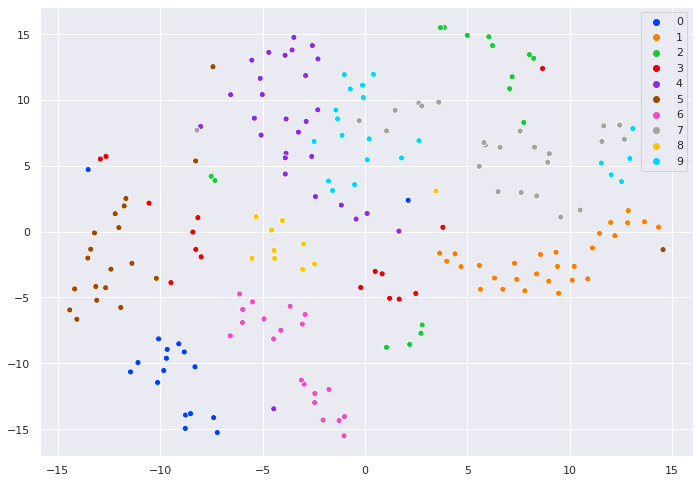

In [49]:
# t-SNE для латентного представления
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

data,labels = next(iter(test_loader))
data = models['64'].E(data.view(-1, 28*28))
data_embedded = TSNE(n_components=2).fit_transform(data.detach().numpy())
sns.scatterplot(data_embedded[:,0], data_embedded[:,1], hue=labels, legend='full', palette=palette)